# Baseline results: VAE with ResNet Encoder/Decoder

As a baseline, we have a VAE with a common architecture used in computer vision, the resnet.
Here, we will see perturbing the latent space will arbitrarility perturb different factors of the image. Moreover, we do not have any intuition as to what aspects of the latent space correspond to different components of the image (e.g. color). One would have to do combinatorial search over all the latent dimensions to qualitatively map latent dimensions to components of an image.

In [20]:
import math
import os
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import normflows as nf
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets.utils as dataset_utils
from PIL import Image
from pl_bolts.models.autoencoders.components import resnet18_decoder, resnet18_encoder
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from gendis.datasets import CausalMNIST, ClusteredMultiDistrDataModule
from gendis.model import NeuralClusteredASCMFlow
from gendis.variational.vae import VAE

In [16]:
def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = (
        imgs.dtype == torch.int32
        if isinstance(imgs, torch.Tensor)
        else imgs[0].dtype == torch.int32
    )
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs / nrow))
    imgs = torchvision.utils.make_grid(
        imgs, nrow=nrow, pad_value=128 if is_int else 0.5
    )
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5 * nrow, 1.5 * ncol))
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

In [25]:
seed = 1
graph_type = "chain"
epoch = 3129
step = 131460
epoch = 6207
step = 260736

epoch = 19881
step = 835044

epoch = 9988
step = 419538

results_dir = Path(
    f"/Users/adam2392/pytorch_data/data/variational/vae-resnet-{graph_type}-seed={seed}/"
)
checkpoint_fname = results_dir / f"epoch={epoch}-step={step}.ckpt"
model = VAE.load_from_checkpoint(checkpoint_fname)

In [26]:
# sample from normal distribution
noise = torch.randn(4, 3)
obs_imgs = model.decoder(noise)  # .reshape(4, 3, 28, 28)
print(obs_imgs.shape)

torch.Size([4, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


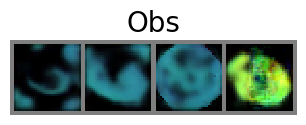

In [27]:
new_obs_imgs = obs_imgs

# new_obs_imgs = torch.zeros_like(obs_imgs)
# for idx, image in enumerate(obs_imgs):
#     new_image = (image - image.min()) / (image.max() - image.min())
#     new_obs_imgs[idx, ...] = new_image
# print(image.min(), image.max())

show_imgs(new_obs_imgs, title="Obs")

In [72]:
checkpoint = torch.load(checkpoint_fname, map_location=lambda storage, loc: storage)
print(checkpoint["epoch"])

9988


## Interventional Experiment

Here, we take a look at the latent dimensions, and apply a perturbation on three randomly chosen batch of variables one at a time. We then compare these to the original image.

The algorithm proceeds by:

1. sampling a random vector for the latent representation and decoding that into an image
2. perturbing the same random vector and decoding the result into an image
3. repeating for different perturbations.

The experiment will demonstrate that the perturbations have not only i) entangled representations of the image concepts (color, fracture, width), but ii) also are by construction unpredictable. 